# <font color = 'red'> ЛР9. Бэггинг и случайные леса </font>

Сложность: <font color = 'Orange'> Средне  </font>.

Дата составления: 12.12.2023

Срок выполнения: 1 неделя (с момента первой практики после выдачи).

Автор: ст. преподаватель Кушнеров А.В.

## Задание 1.

Используя пример из документации,  изучите разложение ошибки в модели регрессии и влияние на неё бэггинга. 
Реализуйте пример. 
Предствьте краткие выводы в текстовой ячейке.  

https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


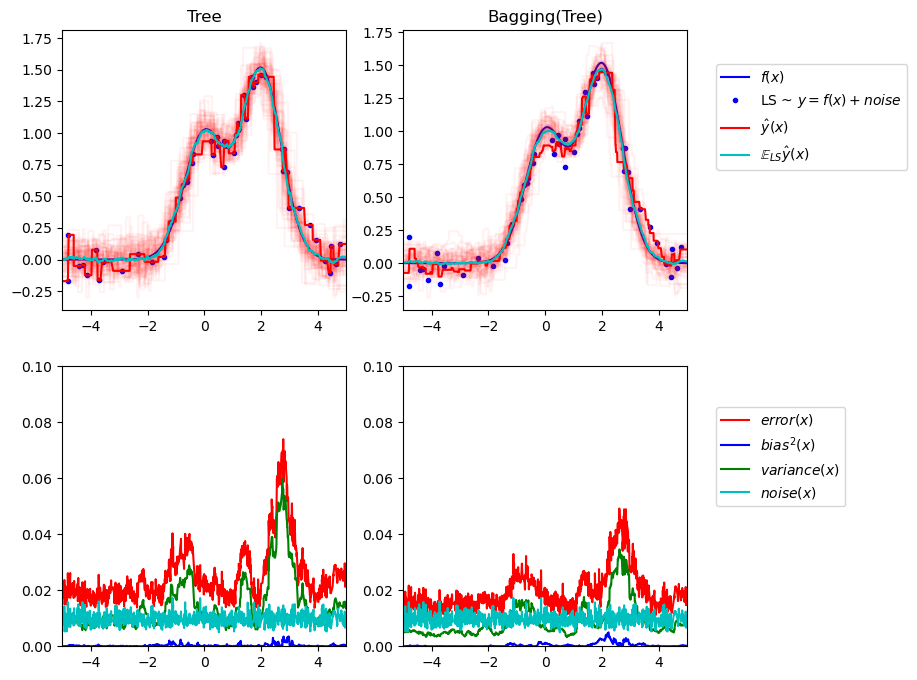

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

1. **Смещение (Bias):** Эффект смещения измеряет, насколько средний прогноз модели отличается от лучшей возможной модели. По сравнению с одиночным деревом решений, бэггинг приводит к небольшому увеличению смещения. Т.е. средний прогноз бэггинг-ансамбля ближе к истинной функции, чем средний прогноз одиночного дерева.

2. **Разброс (Variance):** Эффект разброса измеряет, насколько варьируются прогнозы модели в зависимости от случайного выбора обучающего набора. Бэггинг существенно снижает разброс по сравнению с одиночным деревом решений. 

3. **Шум (Noise):** Шум представляет собой неустранимую часть ошибки, вызванную вариабельностью в данных. Бэггинг не влияет на шум, так как он остается постоянным и около 0.01.

4. **Общая среднеквадратичная ошибка:** В итоге бэггинг приводит к снижению общей среднеквадратичной ошибки (красные кривые на нижних графиках). Это подтверждает, что баланс между увеличением смещения и снижением разброса, достигаемый бэггингом, приводит к улучшению качества модели.

Бэггинг позволяет улучшить обобщающую способность модели, уменьшив разбросив разброс, жертвуя небольшим увеличением смещения.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn import svm, datasets
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [4]:
import warnings
warnings.filterwarnings("ignore") 

## Задание 2. 

Для каждого из подзаданий:

1. Проведите предварительную обработку данных.
2. Постройте модель регрессии на основе метода дерева решений, бэггинга с деревом решений, случайного леса. 
3. Постройте модель регрессии на основе метода ближйших соседей, бэггинга ближйших соседей. 
4. Графически изобразите результаты классификации. 
5. Подберите оптимальные гиперпараметры модели используя различные оценки.
6. Сделайте выводы о точности моделей. Сравниете результаты для моделей из пункта 2-3. 
7. Обязательно в одном из заданий реализуйте прроцедуру бэггинга без встроенных решений.


### 2.1 Погодные условия во время второй мировой

https://www.kaggle.com/datasets/smid80/weatherww2/data

In [5]:
data1 = pd.read_csv('Summary of Weather.csv')
data1

STA        Date Precip  WindGustSpd    MaxTemp    MinTemp  \
0       10001    1942-7-1  1.016          NaN  25.555556  22.222222   
1       10001    1942-7-2      0          NaN  28.888889  21.666667   
2       10001    1942-7-3   2.54          NaN  26.111111  22.222222   
3       10001    1942-7-4   2.54          NaN  26.666667  22.222222   
4       10001    1942-7-5      0          NaN  26.666667  21.666667   
...       ...         ...    ...          ...        ...        ...   
119035  82506  1945-12-27      0          NaN  28.333333  18.333333   
119036  82506  1945-12-28  9.906          NaN  29.444444  18.333333   
119037  82506  1945-12-29      0          NaN  28.333333  18.333333   
119038  82506  1945-12-30      0          NaN  28.333333  18.333333   
119039  82506  1945-12-31      0          NaN  29.444444  17.222222   

         MeanTemp Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  \
0       23.888889      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
1       25.555556      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
2       24.444444      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
3       24.444444      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
4       24.444444      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN   
...           ...      ...         ...  ..  ...  ..  ...  ..  ...         ...   
119035  23.333333      0.0         NaN  45  ... NaN  NaN NaN  NaN         NaN   
119036  23.888889      0.0         1.0  45  ... NaN  NaN NaN  NaN         1.0   
119037  23.333333      0.0         1.0  45  ... NaN  NaN NaN  NaN         1.0   
119038  23.333333      0.0         NaN  45  ... NaN  NaN NaN  NaN         NaN   
119039  23.333333      0.0         NaN  45  ... NaN  NaN NaN  NaN         NaN   

        SD3  RHX  RHN RVG  WTE  
0       NaN  NaN  NaN NaN  NaN  
1       NaN  NaN  NaN NaN  NaN  
2       NaN  NaN  NaN NaN  NaN  
3       NaN  NaN  NaN NaN  NaN  
4       NaN  NaN  NaN NaN  NaN  
...     ...  ...  ...  ..  ...  
119035  NaN  NaN  NaN NaN  NaN  
119036  NaN  NaN  NaN NaN  NaN  
119037  NaN  NaN  NaN NaN  NaN  
119038  NaN  NaN  NaN NaN  NaN  
119039  NaN  NaN  NaN NaN  NaN  

[119040 rows x 31 columns]

In [6]:
 data1.isnull().sum()

STA                 0
Date                0
Precip              0
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1163
PoorWeather     84803
YR                  0
MO                  0
DA                  0
PRCP             1932
DR             118507
SPD            118508
MAX               474
MIN               468
MEA               498
SNF              1163
SND            113477
FT             119040
FB             119040
FTI            119040
ITH            119040
PGT            118515
TSHDSBRSGF      84803
SD3            119040
RHX            119040
RHN            119040
RVG            119040
WTE            119040
dtype: int64

In [7]:
to_drop=['Precip','Date','STA','WindGustSpd','Snowfall','PoorWeather', 'PRCP', 'DR', 'SPD', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
data1.drop(to_drop,inplace=True,axis=1) # 'YR','MO','DA',

In [8]:
data1.isnull().sum()

MaxTemp       0
MinTemp       0
MeanTemp      0
YR            0
MO            0
DA            0
MAX         474
MIN         468
MEA         498
dtype: int64

In [9]:
data1.dropna(axis=1)

MaxTemp    MinTemp   MeanTemp  YR  MO  DA
0       25.555556  22.222222  23.888889  42   7   1
1       28.888889  21.666667  25.555556  42   7   2
2       26.111111  22.222222  24.444444  42   7   3
3       26.666667  22.222222  24.444444  42   7   4
4       26.666667  21.666667  24.444444  42   7   5
...           ...        ...        ...  ..  ..  ..
119035  28.333333  18.333333  23.333333  45  12  27
119036  29.444444  18.333333  23.888889  45  12  28
119037  28.333333  18.333333  23.333333  45  12  29
119038  28.333333  18.333333  23.333333  45  12  30
119039  29.444444  17.222222  23.333333  45  12  31

[119040 rows x 6 columns]

In [10]:
data1=data1[~data1['MeanTemp'].isna()]
data1=data1[~data1['MaxTemp'].isna()]
data1=data1[~data1['MinTemp'].isna()]

<Axes: xlabel='MaxTemp', ylabel='MinTemp'>

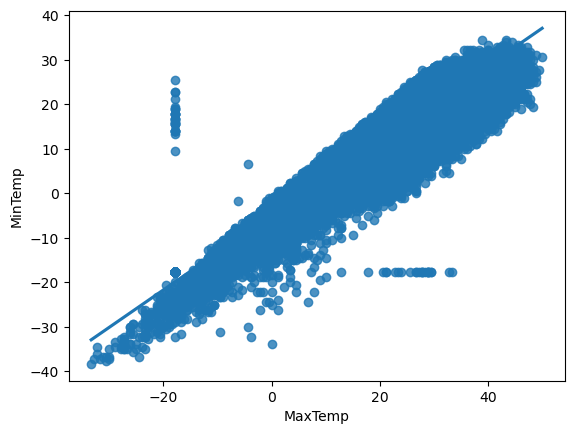

In [11]:
sns.regplot(x="MaxTemp", y="MinTemp", data=data1)

<Axes: >

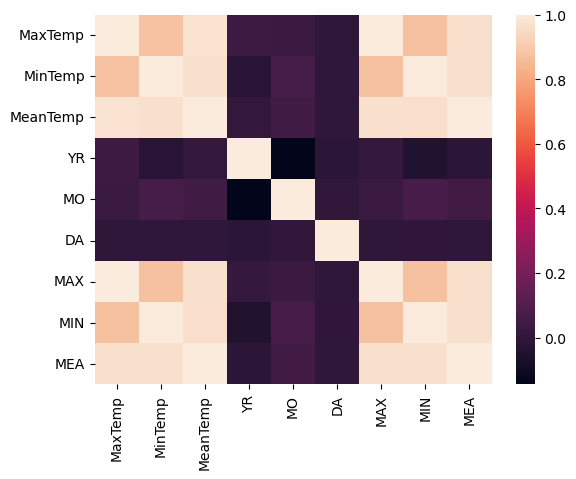

In [12]:
sns.heatmap(data1.corr())

In [14]:
to_drop=['MeanTemp', 'MAX', 'MIN', 'MEA']
data1.drop(to_drop,inplace=True,axis=1) 
target = 'MaxTemp'
X = data1.drop(columns= [target])
y = data1[target]
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size =0.3)

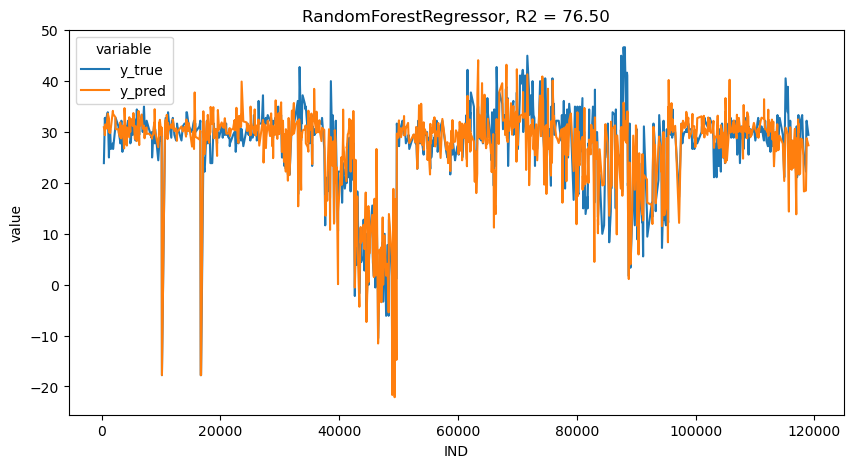

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score

rf_reg = RandomForestRegressor(n_estimators=5, random_state=0)
rf_reg.fit(X_train,y_train)
rf_predict = rf_reg.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,  
    'y_true': y_test,
    'y_pred': rf_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("RandomForestRegressor, R2 = %.2f" % (r2_score(y_test, rf_predict) * 100))
plt.show()

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 20}


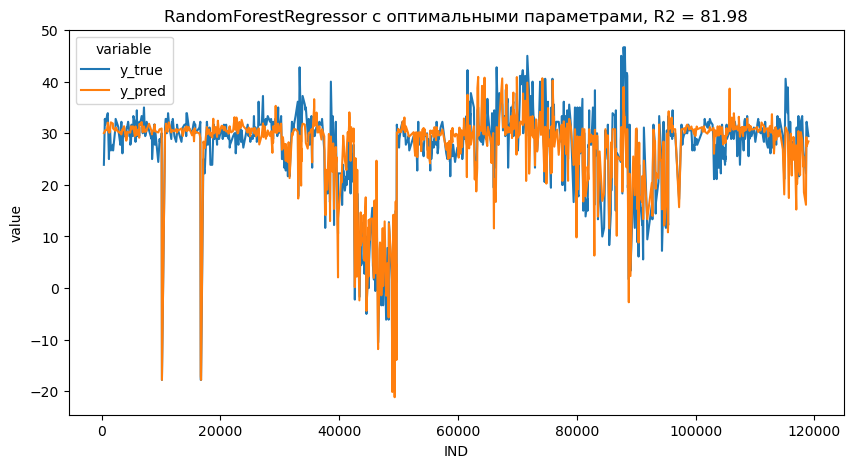

In [46]:
base_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_rf_predict = grid_search.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': best_rf_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("RandomForestRegressor с оптимальными параметрами, R2 = %.2f" % (r2_score(y_test, best_rf_predict) * 100))
plt.show()

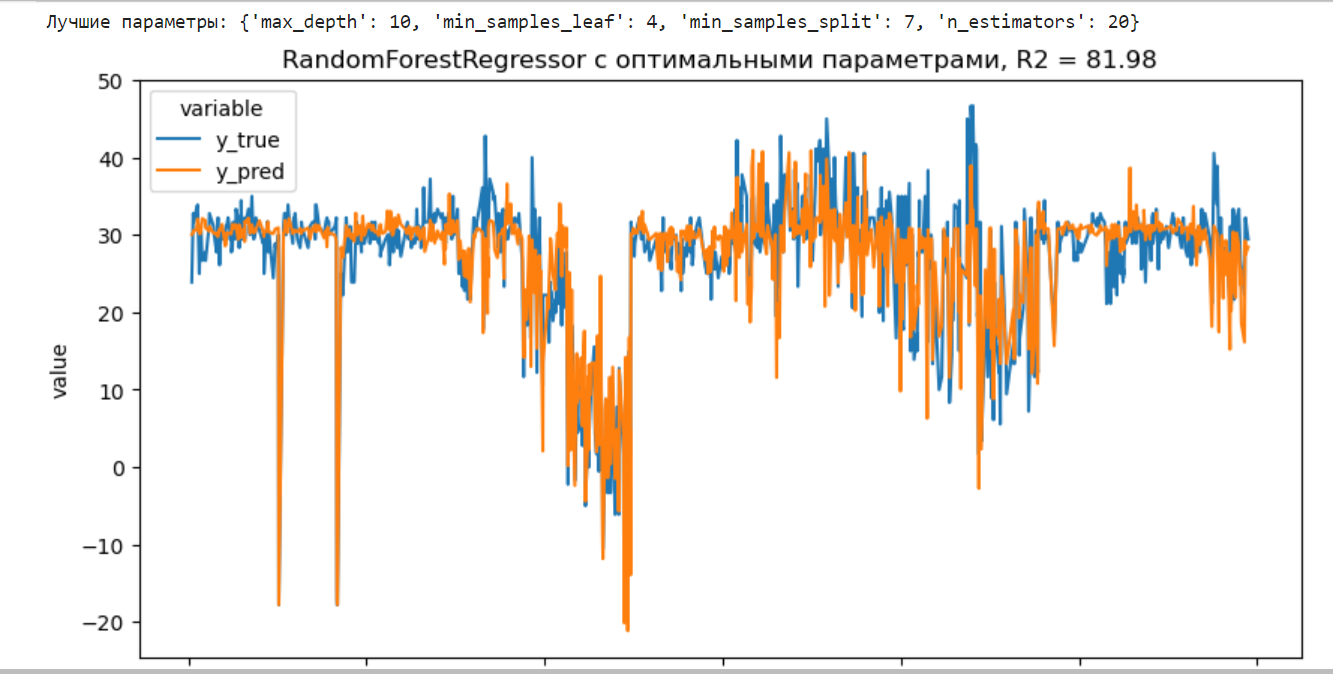

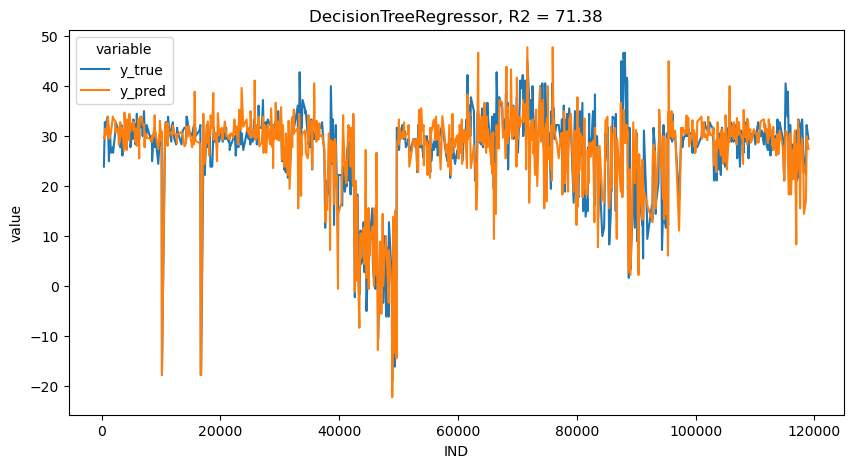

In [38]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)

d_predict = dtree.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': d_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("DecisionTreeRegressor, R2 = %.2f" % (r2_score(y_test, d_predict) * 100))
plt.show()

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


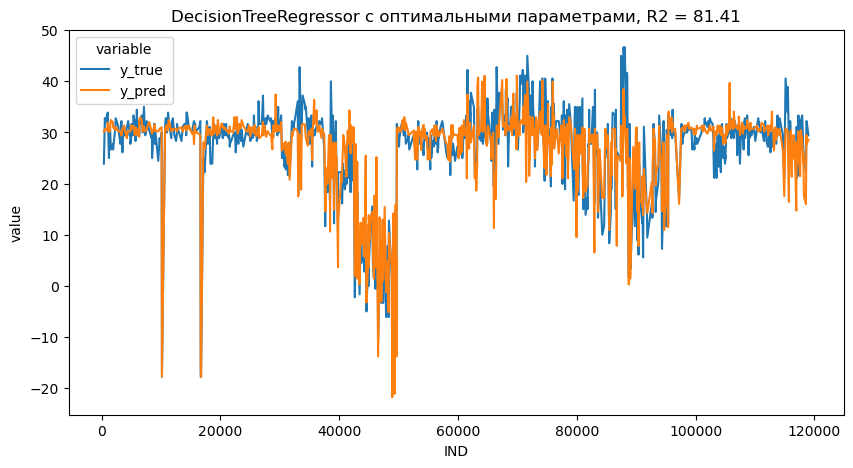

In [42]:
base_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_dt_predict = grid_search.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': best_dt_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("DecisionTreeRegressor с оптимальными параметрами, R2 = %.2f" % (r2_score(y_test, best_dt_predict) * 100))
plt.show()

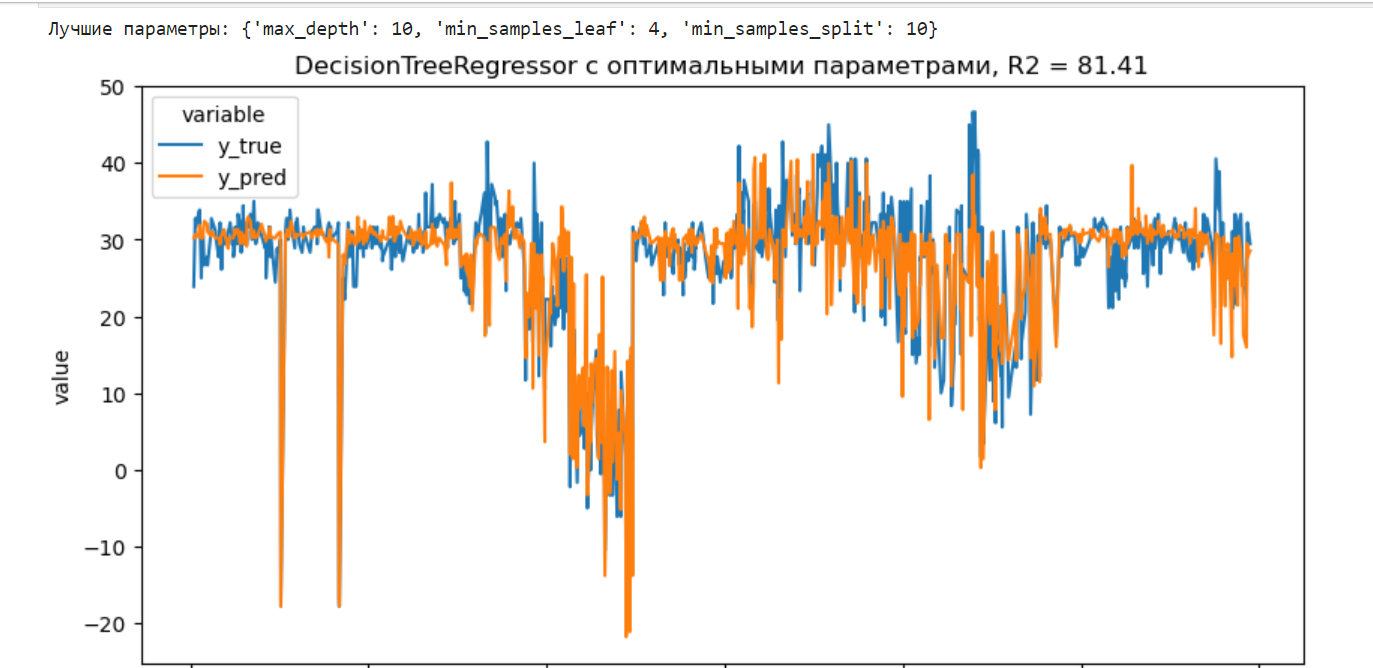

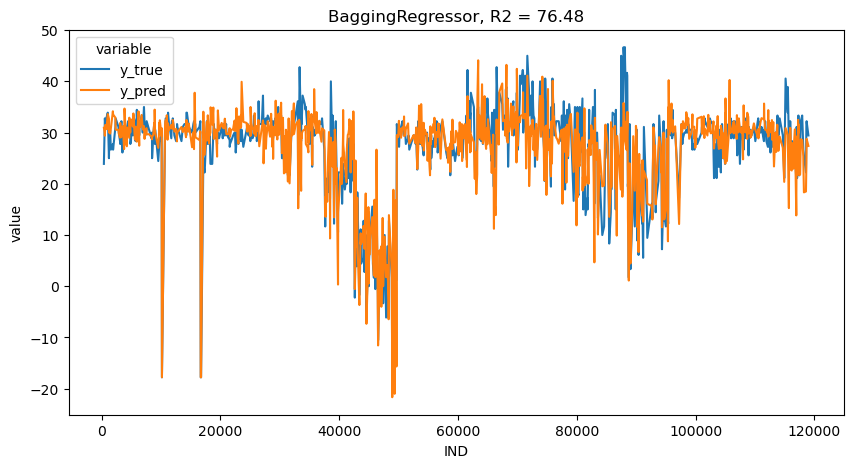

In [39]:
bagging_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5, random_state=0)
bagging_reg.fit(X_train, y_train)

bagging_predict = bagging_reg.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': bagging_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("BaggingRegressor, R2 = %.2f" % (r2_score(y_test, bagging_predict) * 100))
plt.show()

Лучшие параметры: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 20}


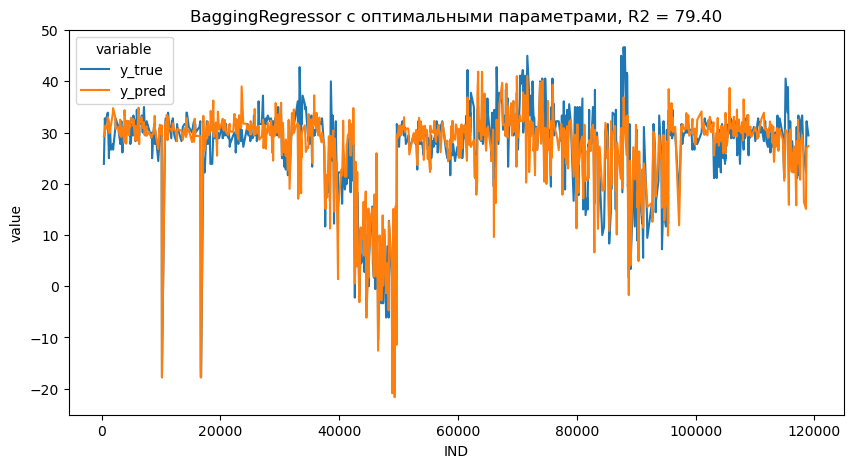

In [40]:
base_model = DecisionTreeRegressor()

bagging_reg = BaggingRegressor(base_model, random_state=0)

param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=bagging_reg, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_bagging_predict = grid_search.predict(X_test)

data_preproc = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': best_bagging_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc[:1000], ['IND']))
plt.title("BaggingRegressor с оптимальными параметрами, R2 = %.2f" % (r2_score(y_test, best_bagging_predict) * 100))
plt.show()

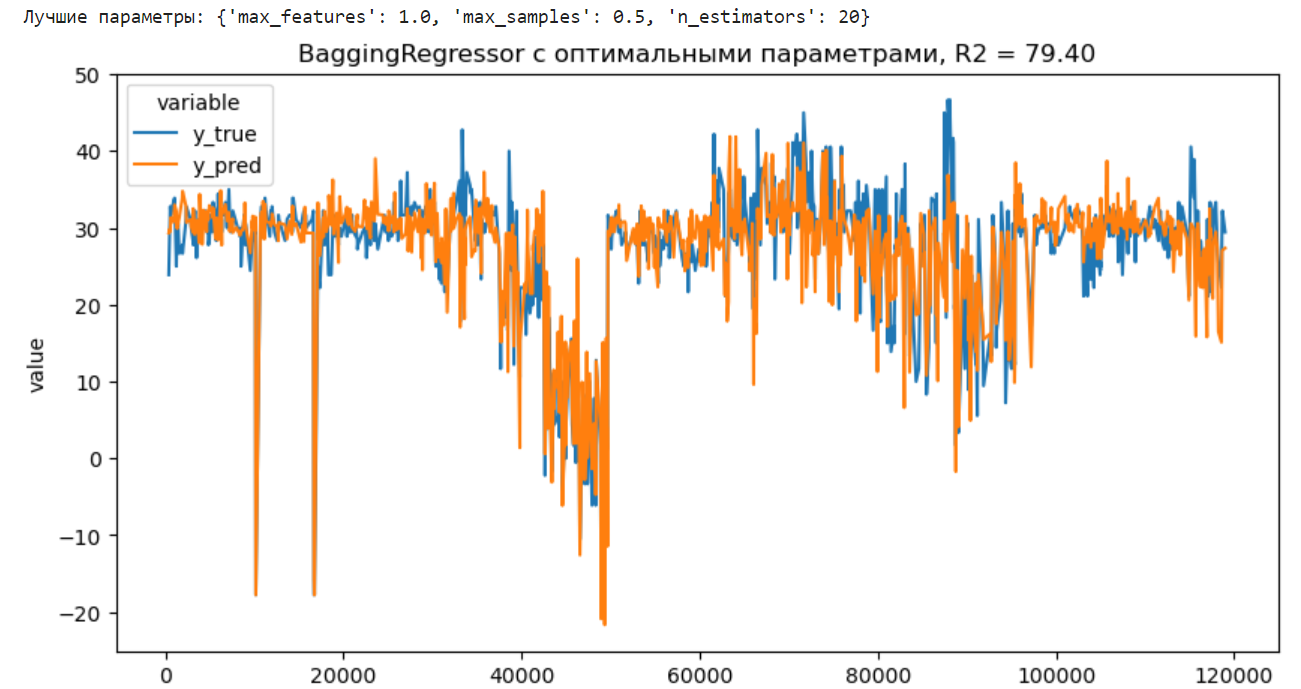

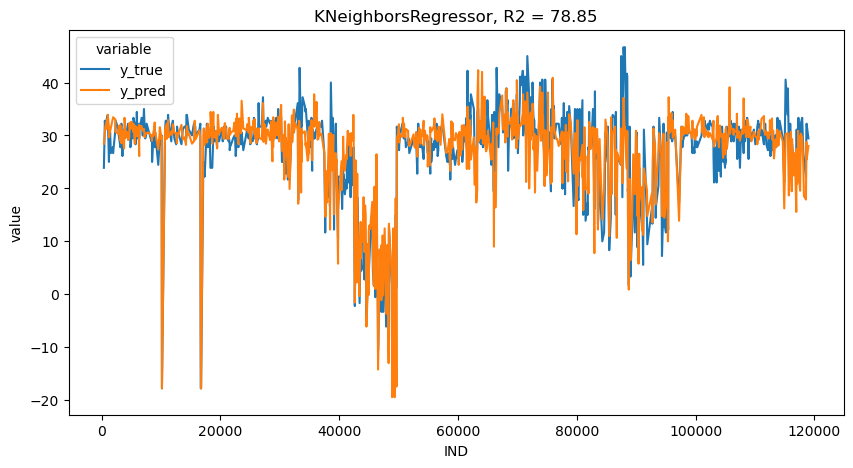

In [47]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=5) 
knn_regressor.fit(X_train, y_train)

knn_predict = knn_regressor.predict(X_test)

data_preproc_knn = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': knn_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc_knn[:1000], ['IND']))
plt.title("KNeighborsRegressor, R2 = %.2f" % (r2_score(y_test, knn_predict) * 100))
plt.show()

Лучшие параметры для KNeighborsRegressor: {'n_neighbors': 10, 'weights': 'uniform'}


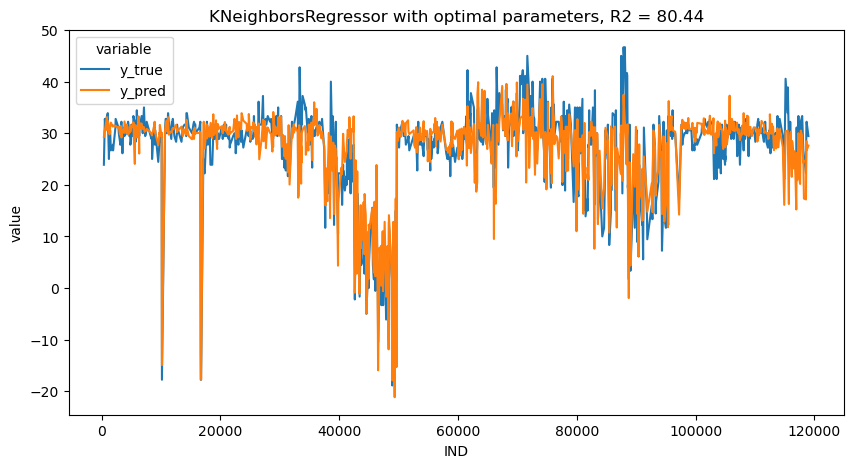

In [49]:
knn_regressor = KNeighborsRegressor()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(estimator=knn_regressor, param_grid=param_grid_knn, cv=5, scoring='r2', n_jobs=-1)

grid_search_knn.fit(X_train, y_train)

print("Лучшие параметры для KNeighborsRegressor:", grid_search_knn.best_params_)

best_knn_predict = grid_search_knn.predict(X_test)

data_preproc_knn = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': best_knn_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc_knn[:1000], ['IND']))
plt.title("KNeighborsRegressor with optimal parameters, R2 = %.2f" % (r2_score(y_test, best_knn_predict) * 100))
plt.show()


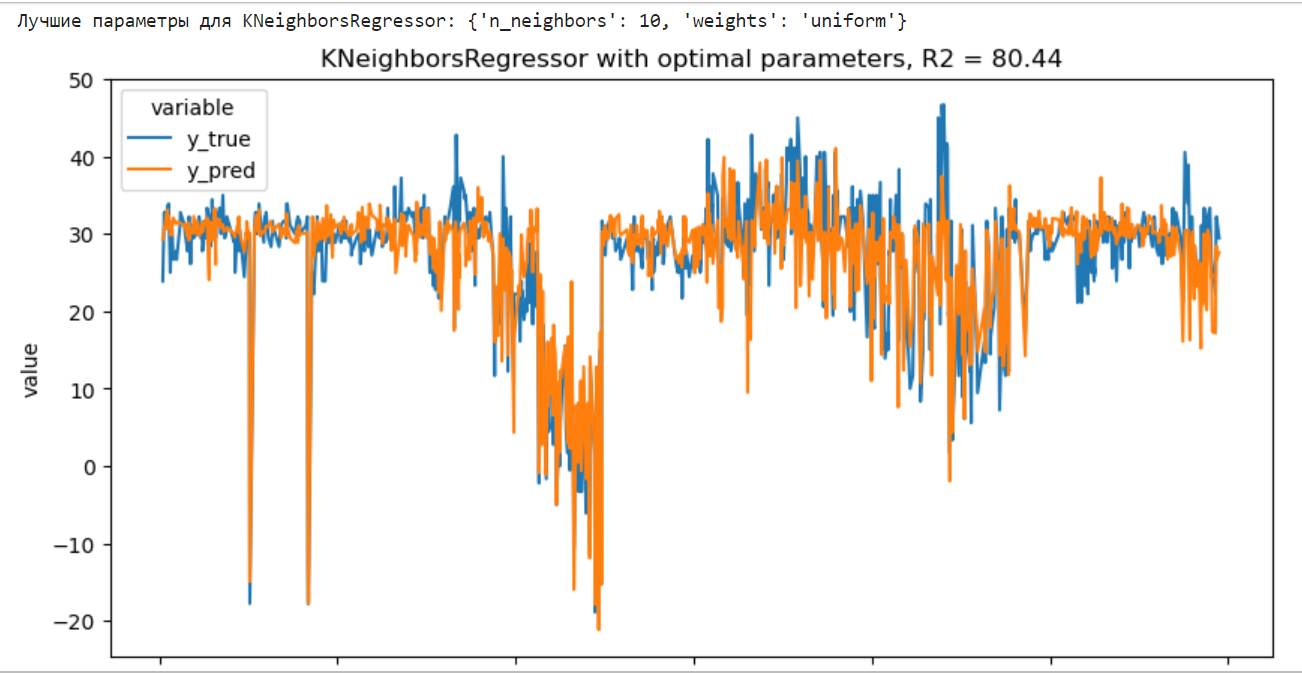

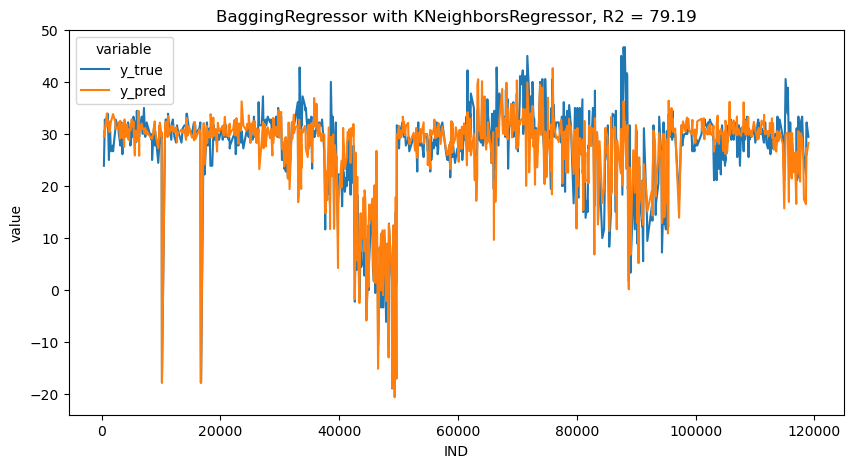

In [48]:
bagging_knn_reg = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=5, random_state=0)
bagging_knn_reg.fit(X_train, y_train)

bagging_knn_predict = bagging_knn_reg.predict(X_test)

data_preproc_bagging_knn = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': bagging_knn_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc_bagging_knn[:1000], ['IND']))
plt.title("BaggingRegressor with KNeighborsRegressor, R2 = %.2f" % (r2_score(y_test, bagging_knn_predict) * 100))
plt.show()

Лучшие параметры для BaggingRegressor with KNeighborsRegressor: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 15}


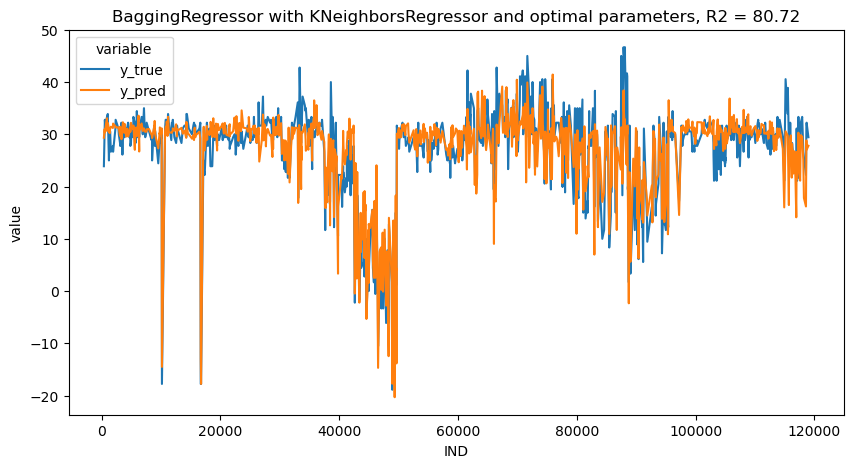

In [50]:
bagging_knn_reg = BaggingRegressor(base_estimator=KNeighborsRegressor(), random_state=0)

param_grid_bagging_knn = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

grid_search_bagging_knn = GridSearchCV(estimator=bagging_knn_reg, param_grid=param_grid_bagging_knn, cv=5, scoring='r2', n_jobs=-1)

grid_search_bagging_knn.fit(X_train, y_train)

print("Лучшие параметры для BaggingRegressor with KNeighborsRegressor:", grid_search_bagging_knn.best_params_)

best_bagging_knn_predict = grid_search_bagging_knn.predict(X_test)

data_preproc_bagging_knn = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': best_bagging_knn_predict
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc_bagging_knn[:1000], ['IND']))
plt.title("BaggingRegressor with KNeighborsRegressor and optimal parameters, R2 = %.2f" % (r2_score(y_test, best_bagging_knn_predict) * 100))
plt.show()

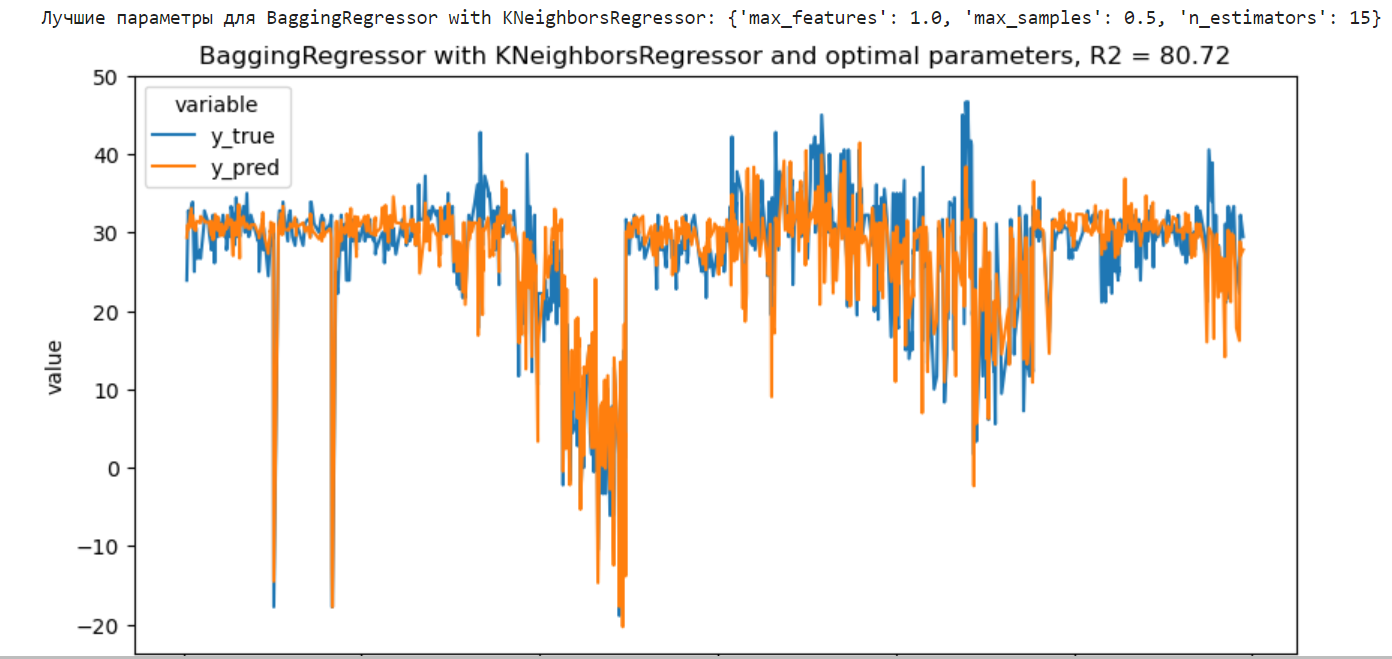

In [113]:
class BootstrapAggregating:
    def fit(self, X_train, y_train, num_trees=30, depth_limit=15):
        self.N, _ = X_train.shape
        self.depth_limit = depth_limit
        self.trees = []

        for b in range(num_trees):
            sample_indices = np.random.choice(np.arange(self.N), size=self.N, replace=True)
            X_train_b = X_train.values[sample_indices]
            y_train_b = y_train.values[sample_indices]

            tree = DecisionTreeRegressor(max_depth=self.depth_limit)
            tree.fit(X_train_b, y_train_b)
            self.trees.append(tree)
            
    def predict(self, X_test):
        y_test_hats = np.empty((len(self.trees), len(X_test)))

        for i, tree in enumerate(self.trees):
            y_test_hats[i] = tree.predict(X_test)

        return y_test_hats.mean(0)
        

In [108]:
target = 'MaxTemp'
X = data1.drop(columns= [target])
y = data1[target]
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size =0.3)

R2 Score: 0.81


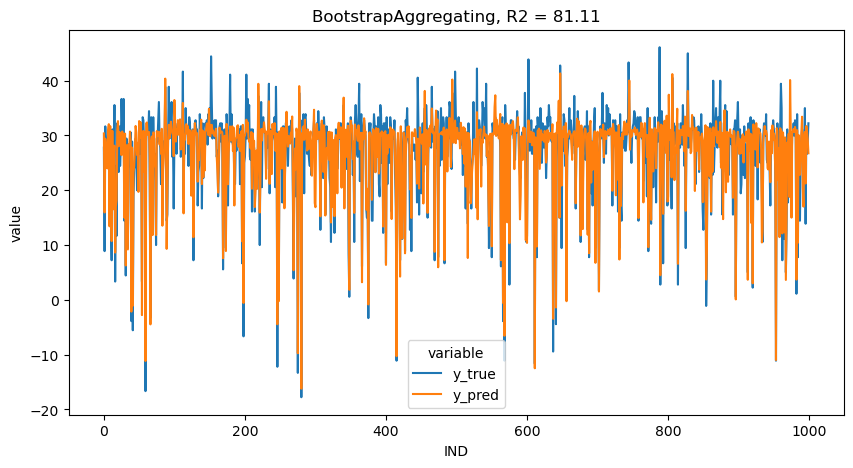

In [114]:
X_test = X_test.reset_index(drop=True)

bagging = BootstrapAggregating()
bagging.fit(X_train, y_train)
y_test_hat = bagging.predict(X_test)

r2 = r2_score(y_test, y_test_hat)
print(f"R2 Score: {r2:.2f}")

data_preproc_bagging = pd.DataFrame({
    'IND': X_test.index,
    'y_true': y_test,
    'y_pred': y_test_hat
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='IND', y='value', hue='variable', 
             data=pd.melt(data_preproc_bagging[:1000], ['IND']))
plt.title("BootstrapAggregating, R2 = %.2f" % (r2 * 100))
plt.show()

## Задание 3. 

Для каждого из подзаданий:

1. Проведите предварительную обработку данных.
2. Постройте модель регресси на основе метода дерева решений, бэггинга с деревом решений, случайного леса. 
3. Постройте модель регресси на основе метода ближйших соседей, бэггинга ближйших соседей. 
4. Графически изобразите результаты классификации. 
5. Подберите оптимальные гиперпараметры модели используя различные оценки.
6. Сделайте выводы о точности моделей. Сравниете результаты для моделей из пункта 2-3. 
7. Постройте валидационные кривые.


### 3.1 Скоринг отказа от услуг оператора связи.

Используйте данные из файла telecom.csv для предсказания отказа от услуг связи. Столбец "churn". 
Предврительно изучите и подготовьте данные.

In [51]:
data2 = pd.read_csv('new_telecom.csv')
data2

account length  international plan  voice mail plan  total day minutes  \
0                128                   0                1              265.1   
1                107                   0                1              161.6   
2                137                   0                0              243.4   
3                 84                   1                0              299.4   
4                 75                   1                0              166.7   
...              ...                 ...              ...                ...   
3328             192                   0                1              156.2   
3329              68                   0                0              231.1   
3330              28                   0                0              180.8   
3331             184                   1                0              213.8   
3332              74                   0                1              234.4   

      total day calls  total eve minutes  total eve calls  \
0                 110              197.4               99   
1                 123              195.5              103   
2                 114              121.2              110   
3                  71               61.9               88   
4                 113              148.3              122   
...               ...                ...              ...   
3328               77              215.5              126   
3329               57              153.4               55   
3330              109              288.8               58   
3331              105              159.6               84   
3332              113              265.9               82   

      total night minutes  total night calls  total intl minutes  \
0                   244.7                 91                10.0   
1                   254.4                103                13.7   
2                   162.6                104                12.2   
3                   196.9                 89                 6.6   
4                   186.9                121                10.1   
...                   ...                ...                 ...   
3328                279.1                 83                 9.9   
3329                191.3                123                 9.6   
3330                191.9                 91                14.1   
3331                139.2                137                 5.0   
3332                241.4                 77                13.7   

      total intl calls  customer service calls  churn  
0                    3                       1      0  
1                    3                       1      0  
2                    5                       0      0  
3                    7                       2      0  
4                    3                       3      0  
...                ...                     ...    ...  
3328                 6                       2      0  
3329                 4                       3      0  
3330                 6                       2      0  
3331                10                       2      0  
3332                 4                       0      0  

[3333 rows x 13 columns]

In [53]:
target = 'churn'
X = data2.drop(columns= [target])
y = data2[target]
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size =0.3)

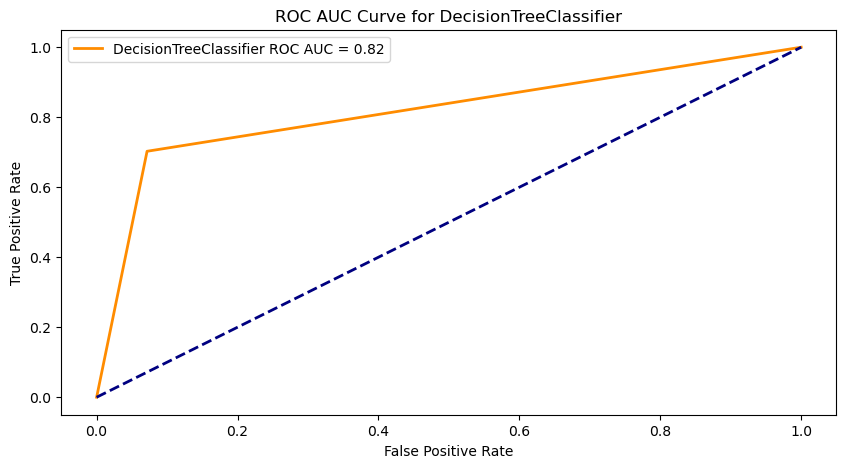

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

dt_predict_proba = dt_classifier.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, dt_predict_proba)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'DecisionTreeClassifier ROC AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for DecisionTreeClassifier')
plt.legend()
plt.show()

Лучшие параметры для DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}


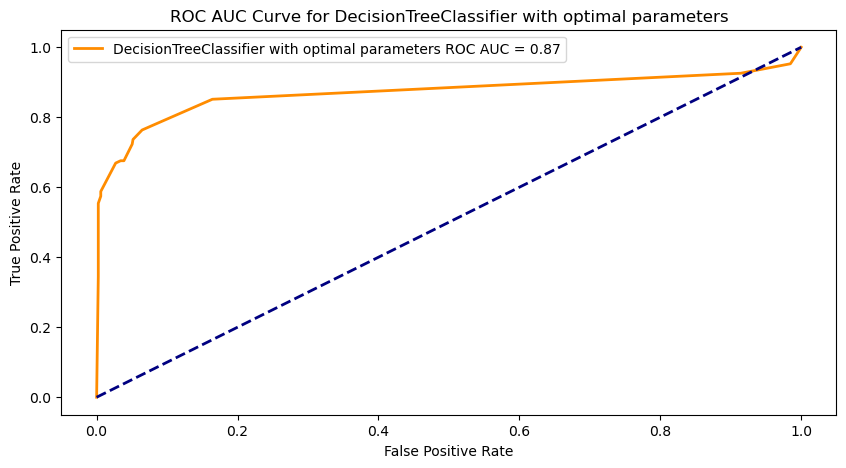

In [57]:
base_model_dt = DecisionTreeClassifier()

param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(estimator=base_model_dt, param_grid=param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print("Лучшие параметры для DecisionTreeClassifier:", grid_search_dt.best_params_)

best_dt_predict_proba = grid_search_dt.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'DecisionTreeClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_dt_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for DecisionTreeClassifier with optimal parameters')
plt.legend()
plt.show()

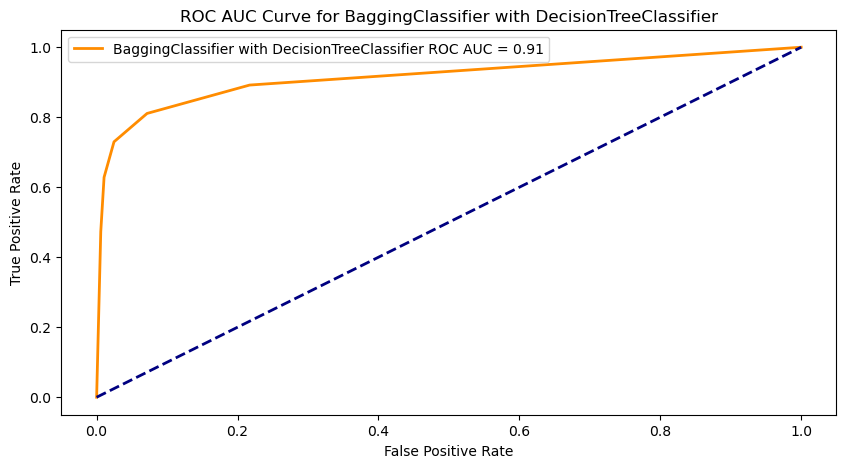

In [55]:
bagging_dt_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5, random_state=0)
bagging_dt_classifier.fit(X_train, y_train)

bagging_dt_predict_proba = bagging_dt_classifier.predict_proba(X_test)[:, 1]
roc_auc_bagging_dt = roc_auc_score(y_test, bagging_dt_predict_proba)

fpr_bagging_dt, tpr_bagging_dt, _ = roc_curve(y_test, bagging_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_dt, tpr_bagging_dt, color='darkorange', lw=2, label=f'BaggingClassifier with DecisionTreeClassifier ROC AUC = {roc_auc_bagging_dt:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with DecisionTreeClassifier')
plt.legend()
plt.show()

Лучшие параметры для BaggingClassifier with DecisionTreeClassifier: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 15}


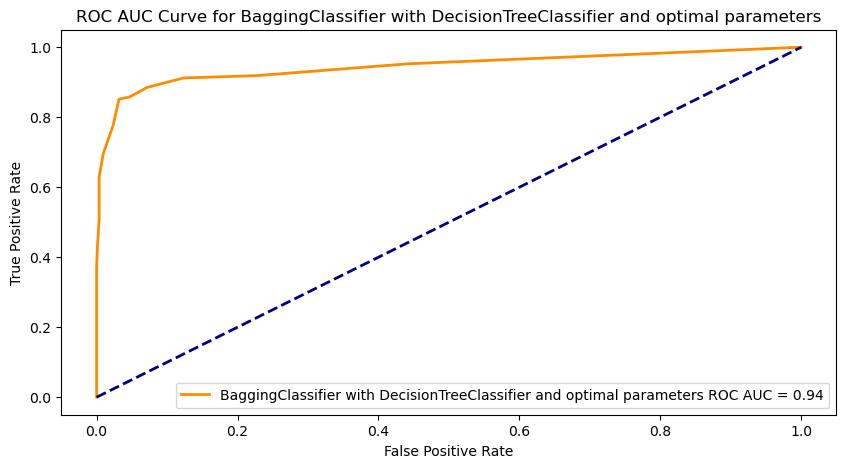

In [58]:
base_model_dt = DecisionTreeClassifier()
bagging_dt_classifier = BaggingClassifier(base_estimator=base_model_dt, random_state=0)

param_grid_bagging_dt = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}


grid_search_bagging_dt = GridSearchCV(estimator=bagging_dt_classifier, param_grid=param_grid_bagging_dt, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_bagging_dt.fit(X_train, y_train)

print("Лучшие параметры для BaggingClassifier with DecisionTreeClassifier:", grid_search_bagging_dt.best_params_)

best_bagging_dt_predict_proba = grid_search_bagging_dt.predict_proba(X_test)[:, 1]

fpr_bagging_dt, tpr_bagging_dt, _ = roc_curve(y_test, best_bagging_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_dt, tpr_bagging_dt, color='darkorange', lw=2, label=f'BaggingClassifier with DecisionTreeClassifier and optimal parameters ROC AUC = {roc_auc_score(y_test, best_bagging_dt_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with DecisionTreeClassifier and optimal parameters')
plt.legend()
plt.show()

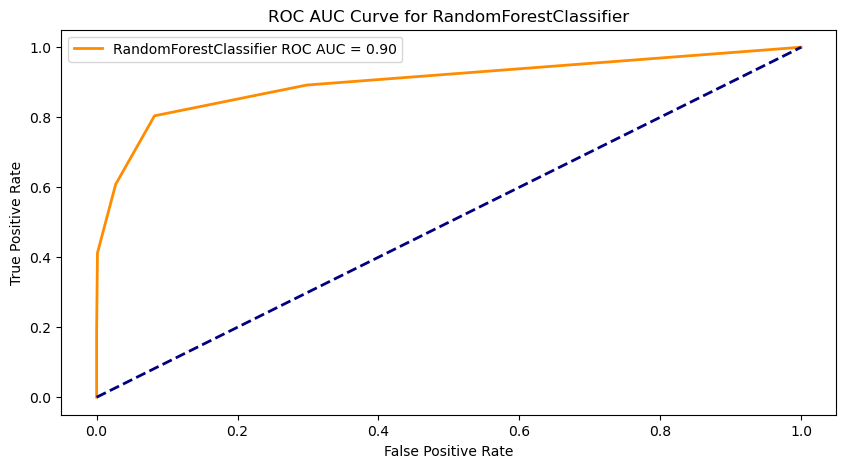

In [56]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
rf_classifier.fit(X_train, y_train)

rf_predict_proba = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, rf_predict_proba)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForestClassifier ROC AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for RandomForestClassifier')
plt.legend()
plt.show()

Лучшие параметры для RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}


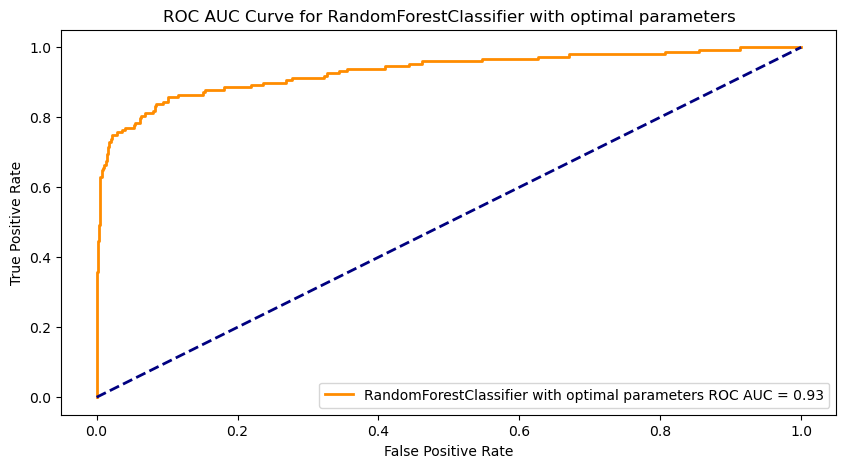

In [60]:
base_model_rf = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [10, 20],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_rf = GridSearchCV(estimator=base_model_rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print("Лучшие параметры для RandomForestClassifier:", grid_search_rf.best_params_)

best_rf_predict_proba = grid_search_rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForestClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_rf_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for RandomForestClassifier with optimal parameters')
plt.legend()
plt.show()

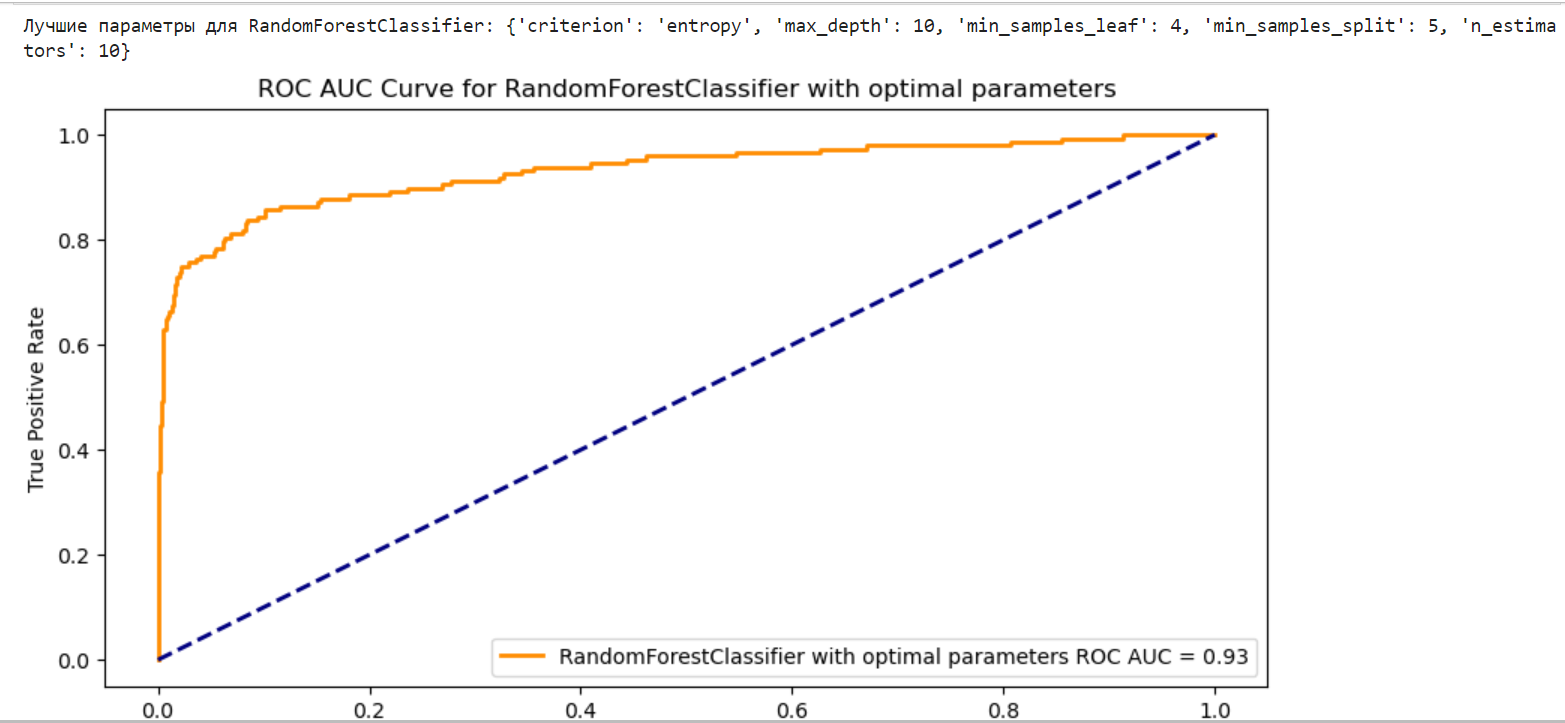

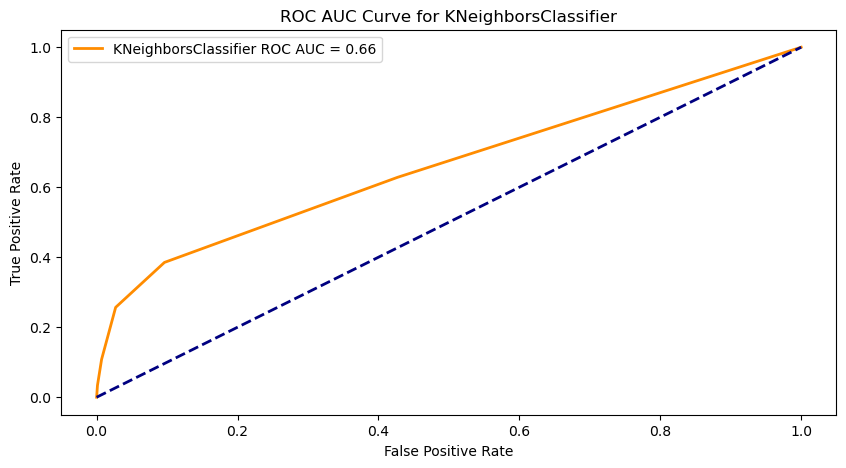

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

knn_predict_proba = knn_classifier.predict_proba(X_test)[:, 1]
roc_auc_knn = roc_auc_score(y_test, knn_predict_proba)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNeighborsClassifier ROC AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for KNeighborsClassifier')
plt.legend()
plt.show()

Лучшие параметры для KNeighborsClassifier: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


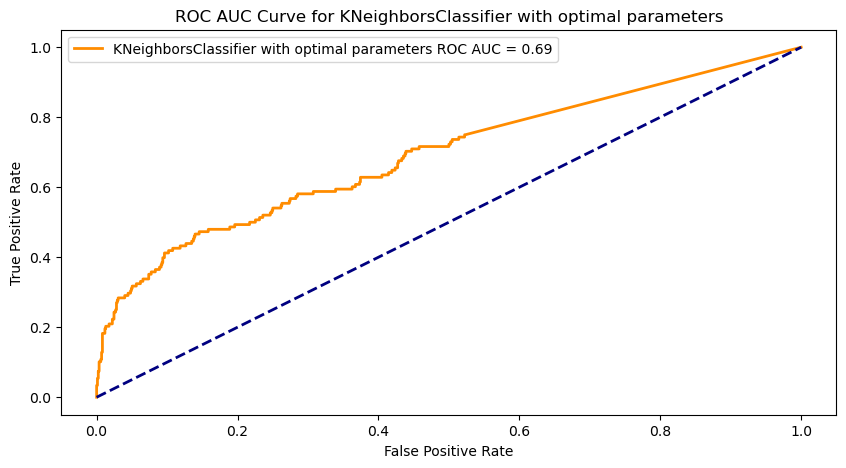

In [64]:
base_model_knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(estimator=base_model_knn, param_grid=param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_knn.fit(X_train, y_train)

print("Лучшие параметры для KNeighborsClassifier:", grid_search_knn.best_params_)

best_knn_predict_proba = grid_search_knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNeighborsClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_knn_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for KNeighborsClassifier with optimal parameters')
plt.legend()
plt.show()

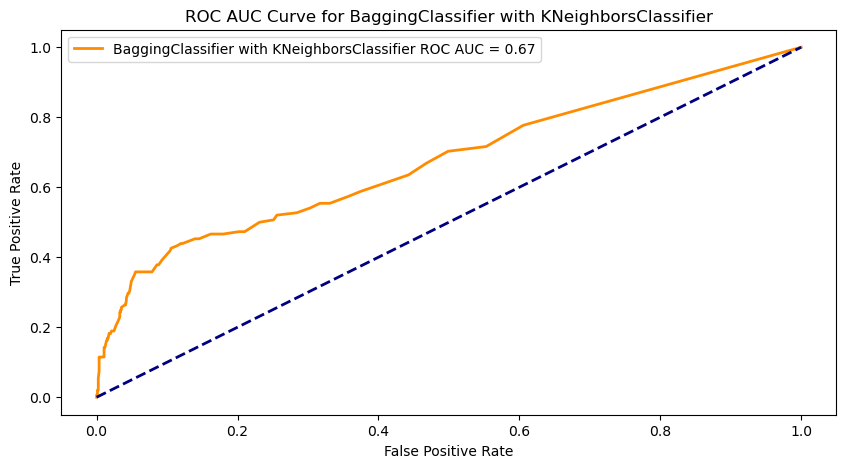

In [63]:
bagging_knn_classifier = BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=0)
bagging_knn_classifier.fit(X_train, y_train)

bagging_knn_predict_proba = bagging_knn_classifier.predict_proba(X_test)[:, 1]
roc_auc_bagging_knn = roc_auc_score(y_test, bagging_knn_predict_proba)

fpr_bagging_knn, tpr_bagging_knn, _ = roc_curve(y_test, bagging_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_knn, tpr_bagging_knn, color='darkorange', lw=2, label=f'BaggingClassifier with KNeighborsClassifier ROC AUC = {roc_auc_bagging_knn:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with KNeighborsClassifier')
plt.legend()
plt.show()

Лучшие параметры для BaggingClassifier with KNeighborsClassifier: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 15}


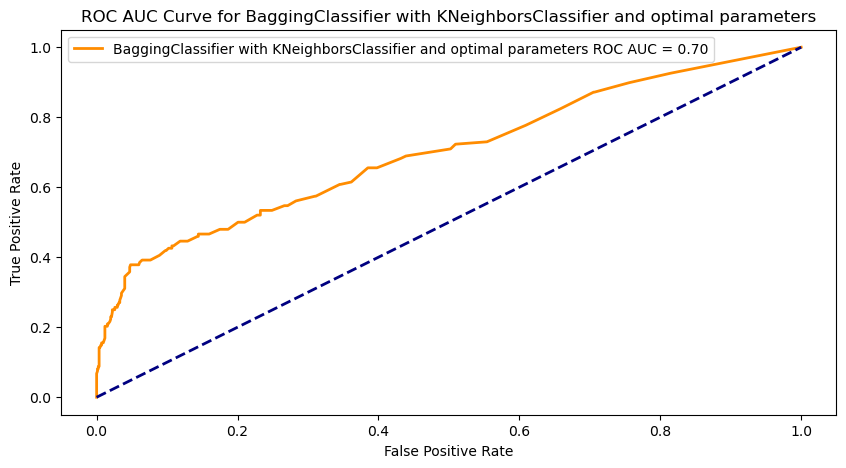

In [65]:
base_model_bagging_knn = KNeighborsClassifier()

bagging_knn_classifier = BaggingClassifier(base_estimator=base_model_bagging_knn, random_state=0)

param_grid_bagging_knn = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

grid_search_bagging_knn = GridSearchCV(estimator=bagging_knn_classifier, param_grid=param_grid_bagging_knn, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_bagging_knn.fit(X_train, y_train)

print("Лучшие параметры для BaggingClassifier with KNeighborsClassifier:", grid_search_bagging_knn.best_params_)

best_bagging_knn_predict_proba = grid_search_bagging_knn.predict_proba(X_test)[:, 1]

fpr_bagging_knn, tpr_bagging_knn, _ = roc_curve(y_test, best_bagging_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_knn, tpr_bagging_knn, color='darkorange', lw=2, label=f'BaggingClassifier with KNeighborsClassifier and optimal parameters ROC AUC = {roc_auc_score(y_test, best_bagging_knn_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with KNeighborsClassifier and optimal parameters')
plt.legend()
plt.show()

### 3.2 Предсказание диабета у пациентов.

Используйте данные из файла diabetes.csv для предсказания исхода для пациентов. Столбец "outcome". Предварительно изучите и подготовьте данные. 

In [66]:
data3 = pd.read_csv('diabetes.csv')
data3

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [67]:
data3["SkinThickness"] = data3["SkinThickness"].replace(0, np.NaN)
data3["Insulin"] = data3["Insulin"].replace(0, np.NaN)
data3["BMI"] = data3["BMI"].replace(0, np.NaN)

In [68]:
medians = data3.median() 
data3 = data3.fillna(medians)

In [70]:
y = data3['Outcome']
X = data3.drop(['Outcome'], axis=1)

In [71]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size =0.3)

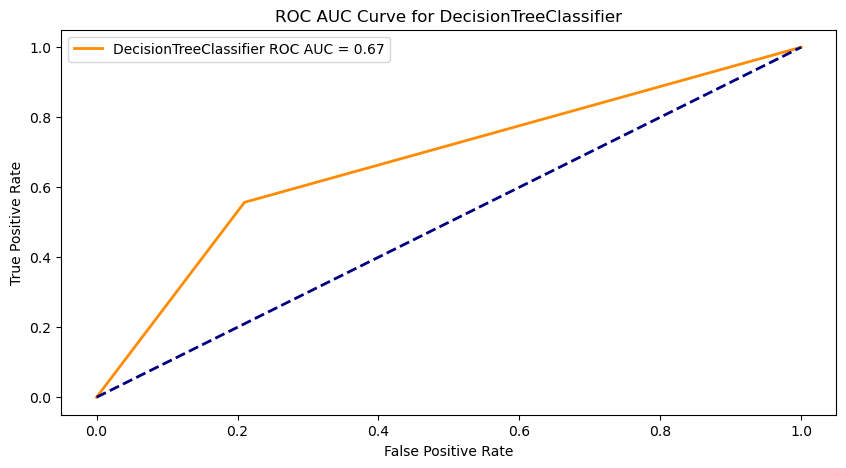

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

dt_predict_proba = dt_classifier.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, dt_predict_proba)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'DecisionTreeClassifier ROC AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for DecisionTreeClassifier')
plt.legend()
plt.show()

Лучшие параметры для DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


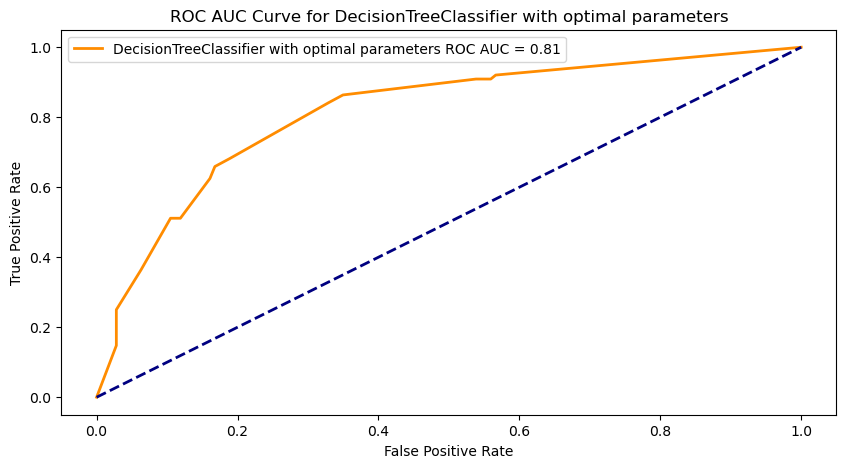

In [75]:
base_model_dt = DecisionTreeClassifier()

param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(estimator=base_model_dt, param_grid=param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print("Лучшие параметры для DecisionTreeClassifier:", grid_search_dt.best_params_)

best_dt_predict_proba = grid_search_dt.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'DecisionTreeClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_dt_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for DecisionTreeClassifier with optimal parameters')
plt.legend()
plt.show()

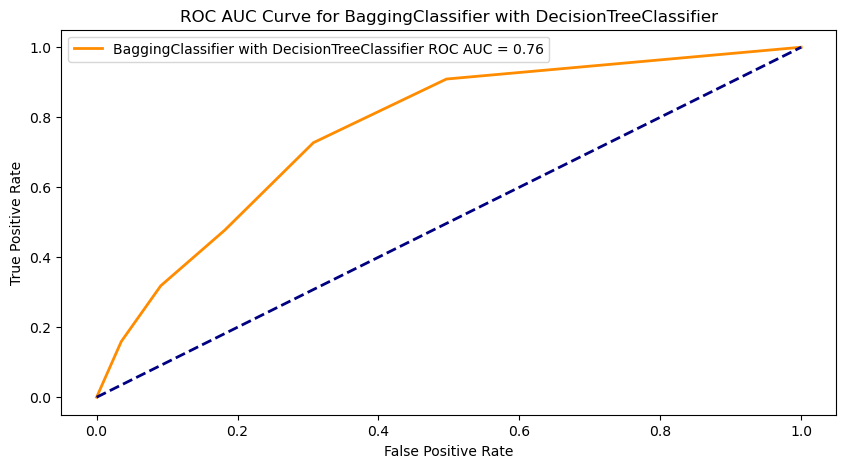

In [76]:
bagging_dt_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5, random_state=0)
bagging_dt_classifier.fit(X_train, y_train)

bagging_dt_predict_proba = bagging_dt_classifier.predict_proba(X_test)[:, 1]
roc_auc_bagging_dt = roc_auc_score(y_test, bagging_dt_predict_proba)

fpr_bagging_dt, tpr_bagging_dt, _ = roc_curve(y_test, bagging_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_dt, tpr_bagging_dt, color='darkorange', lw=2, label=f'BaggingClassifier with DecisionTreeClassifier ROC AUC = {roc_auc_bagging_dt:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with DecisionTreeClassifier')
plt.legend()
plt.show()

Лучшие параметры для BaggingClassifier with DecisionTreeClassifier: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 15}


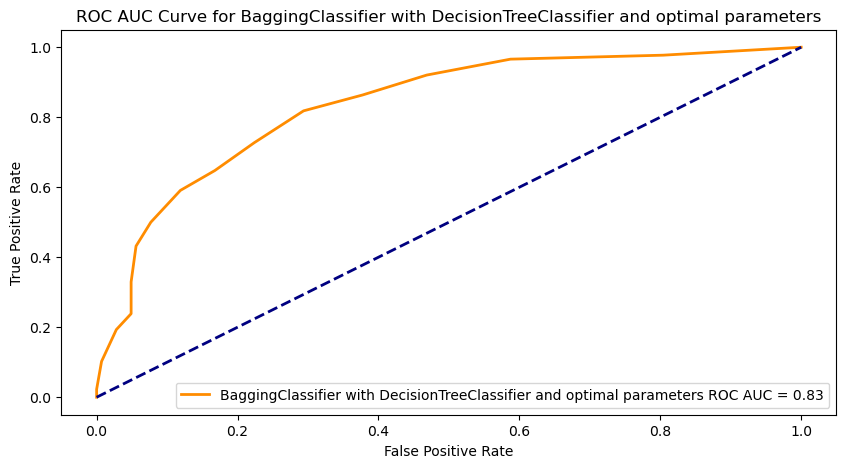

In [77]:
base_model_dt = DecisionTreeClassifier()
bagging_dt_classifier = BaggingClassifier(base_estimator=base_model_dt, random_state=0)

param_grid_bagging_dt = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}


grid_search_bagging_dt = GridSearchCV(estimator=bagging_dt_classifier, param_grid=param_grid_bagging_dt, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_bagging_dt.fit(X_train, y_train)

print("Лучшие параметры для BaggingClassifier with DecisionTreeClassifier:", grid_search_bagging_dt.best_params_)

best_bagging_dt_predict_proba = grid_search_bagging_dt.predict_proba(X_test)[:, 1]

fpr_bagging_dt, tpr_bagging_dt, _ = roc_curve(y_test, best_bagging_dt_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_dt, tpr_bagging_dt, color='darkorange', lw=2, label=f'BaggingClassifier with DecisionTreeClassifier and optimal parameters ROC AUC = {roc_auc_score(y_test, best_bagging_dt_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with DecisionTreeClassifier and optimal parameters')
plt.legend()
plt.show()

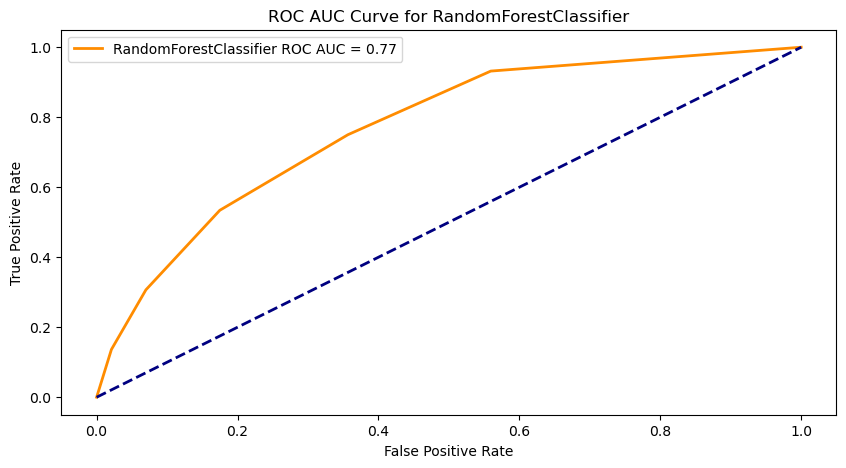

In [78]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
rf_classifier.fit(X_train, y_train)

rf_predict_proba = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, rf_predict_proba)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForestClassifier ROC AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for RandomForestClassifier')
plt.legend()
plt.show()

Лучшие параметры для RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 20}


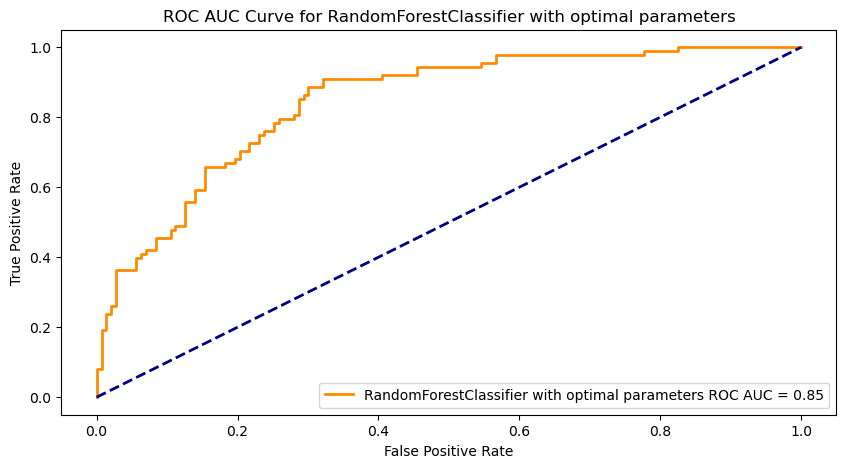

In [79]:
base_model_rf = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [10, 20],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_rf = GridSearchCV(estimator=base_model_rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print("Лучшие параметры для RandomForestClassifier:", grid_search_rf.best_params_)

best_rf_predict_proba = grid_search_rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForestClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_rf_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for RandomForestClassifier with optimal parameters')
plt.legend()
plt.show()

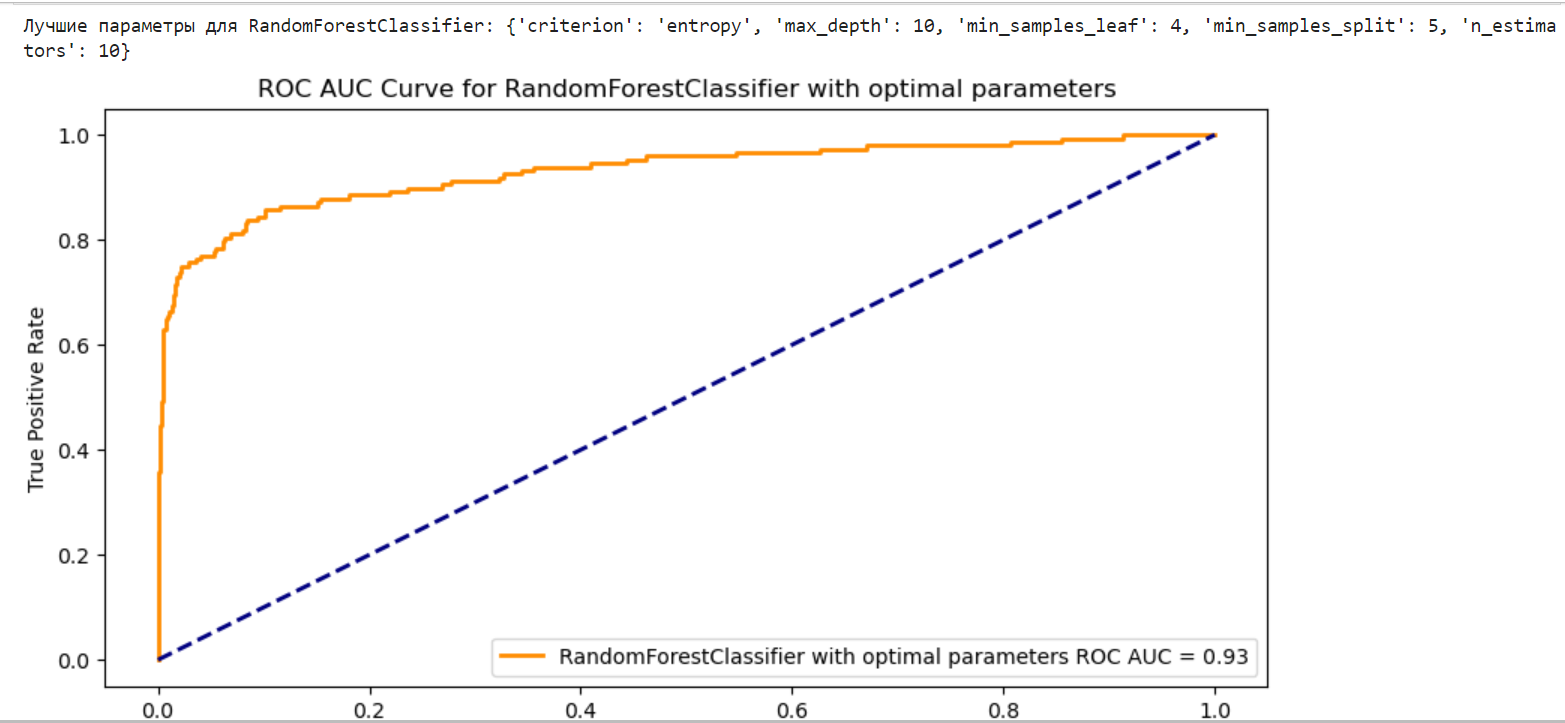

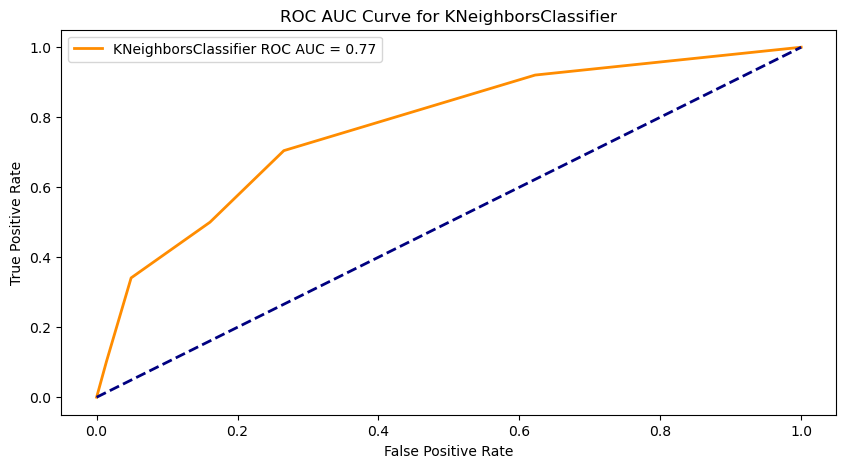

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

knn_predict_proba = knn_classifier.predict_proba(X_test)[:, 1]
roc_auc_knn = roc_auc_score(y_test, knn_predict_proba)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNeighborsClassifier ROC AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for KNeighborsClassifier')
plt.legend()
plt.show()

Лучшие параметры для KNeighborsClassifier: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


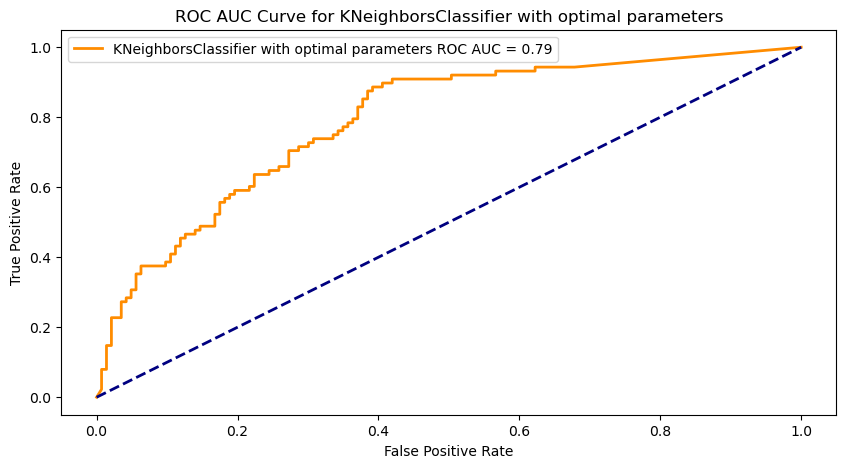

In [81]:
base_model_knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(estimator=base_model_knn, param_grid=param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_knn.fit(X_train, y_train)

print("Лучшие параметры для KNeighborsClassifier:", grid_search_knn.best_params_)

best_knn_predict_proba = grid_search_knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNeighborsClassifier with optimal parameters ROC AUC = {roc_auc_score(y_test, best_knn_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for KNeighborsClassifier with optimal parameters')
plt.legend()
plt.show()

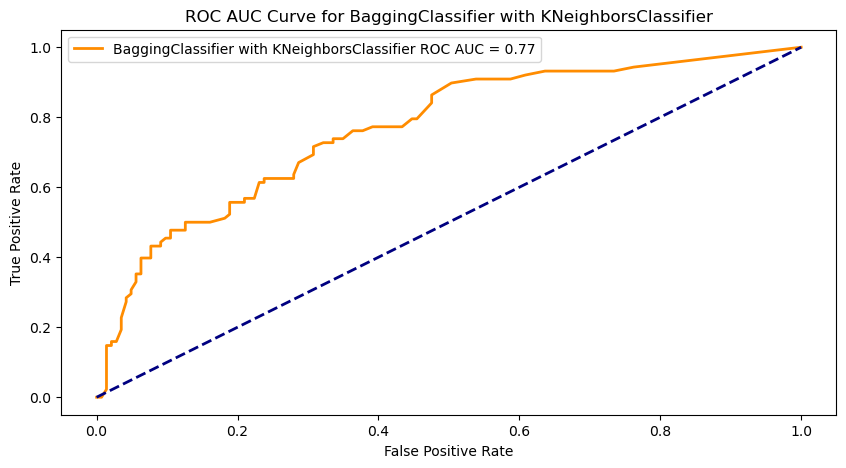

In [82]:
bagging_knn_classifier = BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=0)
bagging_knn_classifier.fit(X_train, y_train)

bagging_knn_predict_proba = bagging_knn_classifier.predict_proba(X_test)[:, 1]
roc_auc_bagging_knn = roc_auc_score(y_test, bagging_knn_predict_proba)

fpr_bagging_knn, tpr_bagging_knn, _ = roc_curve(y_test, bagging_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_knn, tpr_bagging_knn, color='darkorange', lw=2, label=f'BaggingClassifier with KNeighborsClassifier ROC AUC = {roc_auc_bagging_knn:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with KNeighborsClassifier')
plt.legend()
plt.show()

Лучшие параметры для BaggingClassifier with KNeighborsClassifier: {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 15}


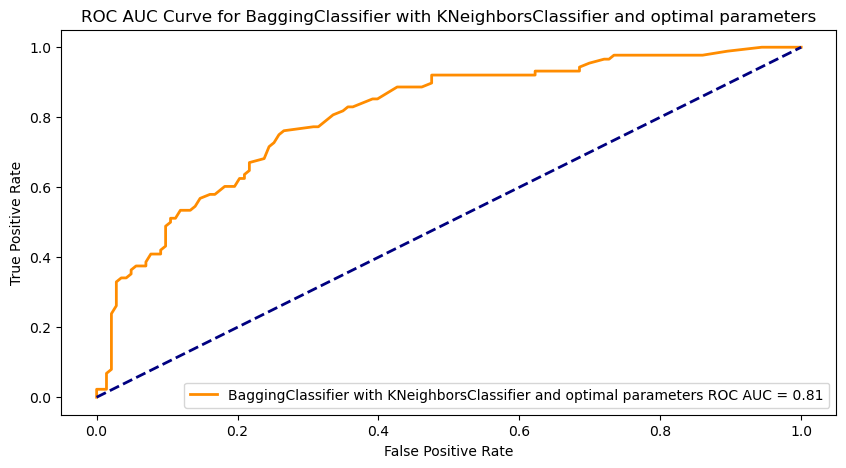

In [83]:
base_model_bagging_knn = KNeighborsClassifier()

bagging_knn_classifier = BaggingClassifier(base_estimator=base_model_bagging_knn, random_state=0)

param_grid_bagging_knn = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

grid_search_bagging_knn = GridSearchCV(estimator=bagging_knn_classifier, param_grid=param_grid_bagging_knn, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_bagging_knn.fit(X_train, y_train)

print("Лучшие параметры для BaggingClassifier with KNeighborsClassifier:", grid_search_bagging_knn.best_params_)

best_bagging_knn_predict_proba = grid_search_bagging_knn.predict_proba(X_test)[:, 1]

fpr_bagging_knn, tpr_bagging_knn, _ = roc_curve(y_test, best_bagging_knn_predict_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging_knn, tpr_bagging_knn, color='darkorange', lw=2, label=f'BaggingClassifier with KNeighborsClassifier and optimal parameters ROC AUC = {roc_auc_score(y_test, best_bagging_knn_predict_proba):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for BaggingClassifier with KNeighborsClassifier and optimal parameters')
plt.legend()
plt.show()

### 3.3 Расознавание рукописных цифр.

In [84]:
from sklearn.datasets import load_digits
digits = load_digits()

In [85]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.3)

Macro-averaged F1 Score for DecisionTreeClassifier: 0.8368


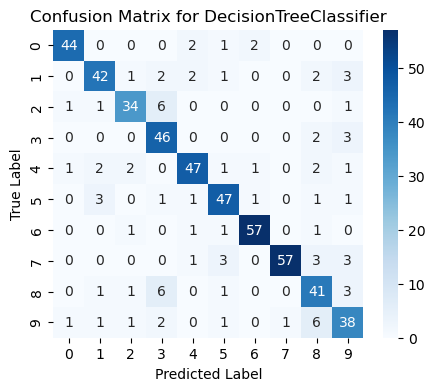

In [88]:
from sklearn.metrics import f1_score

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

dt_predictions = dt_classifier.predict(X_test)

f1_macro = f1_score(y_test, dt_predictions, average='macro')

print(f"Macro-averaged F1 Score for DecisionTreeClassifier: {f1_macro:.4f}")

conf_matrix = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for DecisionTreeClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Лучшие параметры для DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Macro-averaged F1 Score for DecisionTreeClassifier with best parameters: 0.8569


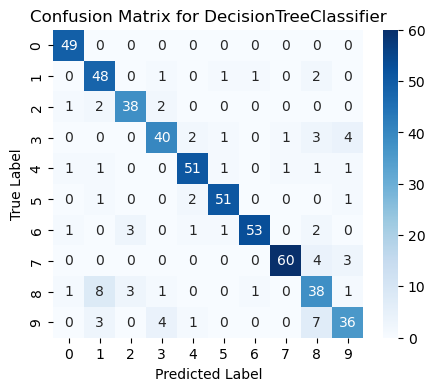

In [90]:
from sklearn.metrics import make_scorer
dt_classifier = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4]
}

scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scorer, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры для DecisionTreeClassifier:", best_params)

best_dt_predictions = grid_search.predict(X_test)

f1_macro_best_params = f1_score(y_test, best_dt_predictions, average='macro')
print(f"Macro-averaged F1 Score for DecisionTreeClassifier with best parameters: {f1_macro_best_params:.4f}")

conf_matrix = confusion_matrix(y_test, best_dt_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for DecisionTreeClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Лучшие параметры для BaggingClassifier with DecisionTreeClassifier: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 15}
Macro-averaged F1 Score for BaggingClassifier with DecisionTreeClassifier and best parameters: 0.9521


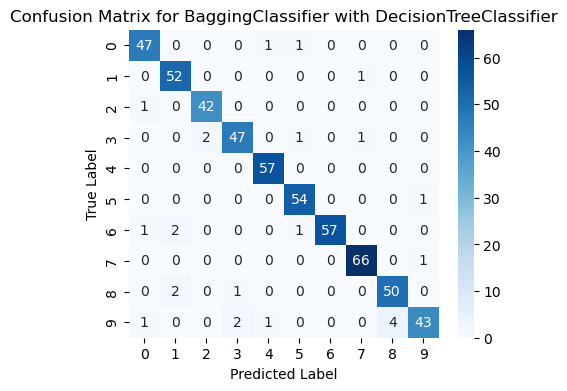

In [91]:
base_model = DecisionTreeClassifier()

bagging_classifier = BaggingClassifier(base_model)

param_grid_bagging = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

scorer_bagging = make_scorer(f1_score, average='macro')

grid_search_bagging = GridSearchCV(estimator=bagging_classifier, param_grid=param_grid_bagging, scoring=scorer_bagging, cv=5)

grid_search_bagging.fit(X_train, y_train)

best_params_bagging = grid_search_bagging.best_params_
print("Лучшие параметры для BaggingClassifier with DecisionTreeClassifier:", best_params_bagging)

best_bagging_predictions = grid_search_bagging.predict(X_test)

f1_macro_best_params_bagging = f1_score(y_test, best_bagging_predictions, average='macro')
print(f"Macro-averaged F1 Score for BaggingClassifier with DecisionTreeClassifier and best parameters: {f1_macro_best_params_bagging:.4f}")

conf_matrix = confusion_matrix(y_test, best_bagging_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for BaggingClassifier with DecisionTreeClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Лучшие параметры для RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
Macro-averaged F1 Score for RandomForestClassifier with best parameters: 0.9630


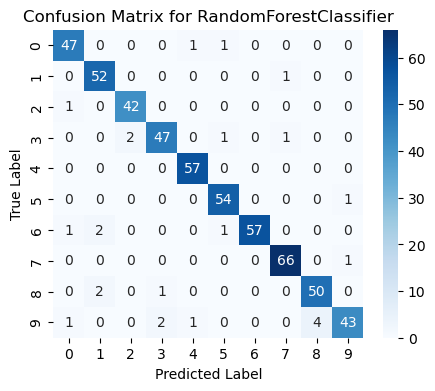

In [93]:
rf_classifier = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [10, 20],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

scorer_rf = make_scorer(f1_score, average='macro')

grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, scoring=scorer_rf, cv=5)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
print("Лучшие параметры для RandomForestClassifier:", best_params_rf)

best_rf_predictions = grid_search_rf.predict(X_test)

f1_macro_best_params_rf = f1_score(y_test, best_rf_predictions, average='macro')
print(f"Macro-averaged F1 Score for RandomForestClassifier with best parameters: {f1_macro_best_params_rf:.4f}")

conf_matrix = confusion_matrix(y_test, best_bagging_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for RandomForestClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Лучшие параметры для KNeighborsClassifier: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Macro-averaged F1 Score for KNeighborsClassifier with best parameters: 0.9885


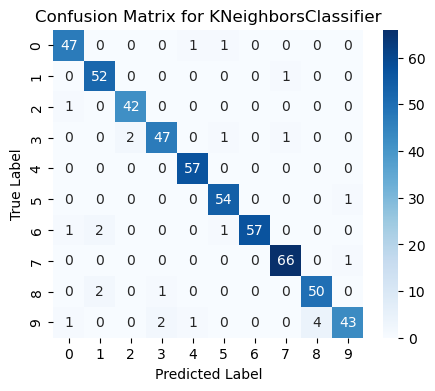

In [94]:
knn_classifier = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

scorer_knn = make_scorer(f1_score, average='macro')

grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, scoring=scorer_knn, cv=5)

grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
print("Лучшие параметры для KNeighborsClassifier:", best_params_knn)

best_knn_predictions = grid_search_knn.predict(X_test)

f1_macro_best_params_knn = f1_score(y_test, best_knn_predictions, average='macro')
print(f"Macro-averaged F1 Score for KNeighborsClassifier with best parameters: {f1_macro_best_params_knn:.4f}")

conf_matrix = confusion_matrix(y_test, best_bagging_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for KNeighborsClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Лучшие параметры для BaggingClassifier with KNeighborsClassifier: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5}
Macro-averaged F1 Score for BaggingClassifier with KNeighborsClassifier and best parameters: 0.9886


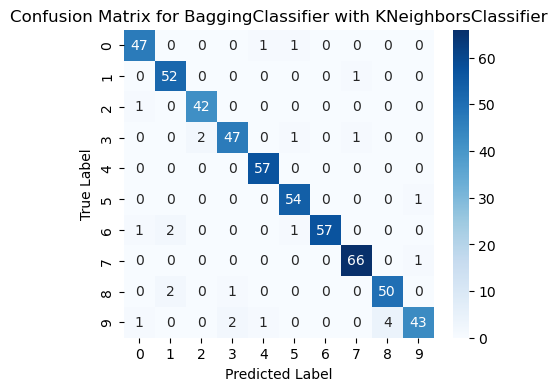

In [95]:
base_model_knn = KNeighborsClassifier()

bagging_classifier_knn = BaggingClassifier(base_model_knn)

param_grid_bagging_knn = {
    'n_estimators': [5, 10, 15],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

scorer_bagging_knn = make_scorer(f1_score, average='macro')

grid_search_bagging_knn = GridSearchCV(estimator=bagging_classifier_knn, param_grid=param_grid_bagging_knn, scoring=scorer_bagging_knn, cv=5)

grid_search_bagging_knn.fit(X_train, y_train)

best_params_bagging_knn = grid_search_bagging_knn.best_params_
print("Лучшие параметры для BaggingClassifier with KNeighborsClassifier:", best_params_bagging_knn)

best_bagging_knn_predictions = grid_search_bagging_knn.predict(X_test)

f1_macro_best_params_bagging_knn = f1_score(y_test, best_bagging_knn_predictions, average='macro')
print(f"Macro-averaged F1 Score for BaggingClassifier with KNeighborsClassifier and best parameters: {f1_macro_best_params_bagging_knn:.4f}")

conf_matrix = confusion_matrix(y_test, best_bagging_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix for BaggingClassifier with KNeighborsClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Ссылки

https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f